In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import tldextract
import matplotlib.pyplot as plt
import seaborn as sns


from tempfile import NamedTemporaryFile
from matplotlib.image import imread
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.lines import Line2D

import statsmodels.formula.api as smf

Helper dictionaries and functions

In [2]:
# PATHS, CHANGE THIS IF NEEDED!
IMAGEPATH = "./"
PATH_MBFC = "./MBFC"
PATH_DF = './'

categories = ["left", "left_center", "mainstream", "right_center", "right"]

color_dict = {
    "left": "#2d6a94", 
    "left_center": "#8768a6", 
    "mainstream": "#368639", 
    "right_center": "#dc7430", 
    "right": "#b73538"
}

title_dict = {
    "left": "Left", 
    "left_center": "Left center", 
    "mainstream": "Mainstream", 
    "right_center": "Right center", 
    "right": "Right"
}

def get_domain(row):
    extracted = tldextract.extract(row["link"].strip())
    return extracted.domain + "." + extracted.suffix

    return extracted.domain + "." + extracted.suffix

def get_media_list(media_list, leaning, country):
    mainstream = pd.read_csv(media_list)
    mainstream = mainstream.loc[mainstream["country"].str.contains("usa", na=False)]
    mainstream["host"] = mainstream.apply(lambda row: get_domain(row), axis=1)
    mainstream = mainstream["host"].to_list()
    return mainstream

def get_all_media_list(media_list, leaning, country):
    mainstream = media_list.loc[media_list["country"] == country]
    mainstream["host"] = mainstream.apply(lambda row: get_domain(row), axis=1)
    mainstream = mainstream["host"].to_list()
    return mainstream

def get_size(fig, dpi=100):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi


def set_size(fig, size, dpi=100, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height  # reasonable starting point
    deltas = []  # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

Process media bias fact check lists

In [3]:
right_media = get_media_list(PATH_MBFC + "right.csv", "123", "usa")
left_media = get_media_list(PATH_MBFC + "left.csv", "123", "usa")
right_center_media = get_media_list(PATH_MBFC + "right-center.csv", "123", "usa")
left_center_media = get_media_list(PATH_MBFC + "leftcenter.csv", "123", "usa")
mainstream = get_media_list(PATH_MBFC + "center.csv", "123", "usa")

fakenews = pd.read_csv(PATH_MBFC + "fake-news.csv")
fakenews = fakenews.loc[fakenews["country"].str.contains("usa", na=False)]
fakenews["host"] = fakenews.apply(lambda row: get_domain(row), axis=1)

right_tag = ["extreme right", "extreme-right", "far right", "far right-bias", "far-right", "right"]
right_center_tag = ["right-center"]
left_tag = ["extreme left", "far left", "far left bias", "left"]
left_center_tag = ["left-center"]
fakenews_right = fakenews.loc[fakenews["bias rating"].isin(right_tag)]["host"].to_list()
fakenews_left = fakenews.loc[fakenews["bias rating"].isin(left_tag)]["host"].to_list()
fakenews_right_center = fakenews.loc[fakenews["bias rating"].isin(right_center_tag)]["host"].to_list()
fakenews_left_center = fakenews.loc[fakenews["bias rating"].isin(left_center_tag)]["host"].to_list()

right_media = right_media + fakenews_right
left_media = left_media + fakenews_left
right_center_media = right_center_media + fakenews_right_center
left_center_media = left_center_media + fakenews_left_center
all_media = right_media + right_center_media + left_media + left_center_media + mainstream

Reads and process quote dataframe

In [4]:
quote_centric_regression = pd.read_csv(PATH_DF + 'dataframe_concise_for_plot.csv')

outlet_mapper = {}
for i in left_media:
    outlet_mapper[i] = "left"
for i in left_center_media:
    outlet_mapper[i] = "left_center"
for i in right_media:
    outlet_mapper[i] = "right"
for i in right_center_media:
    outlet_mapper[i] = "right_center"
for i in mainstream:
    outlet_mapper[i] = "mainstream"

quote_centric_regression["outlet_category"] = quote_centric_regression["domain"].apply(lambda x: outlet_mapper[x])

quote_centric_regression['demeaned'] = quote_centric_regression['unprofessional_verb'] - \
                                       quote_centric_regression['domain_proxy']

In [5]:
quote_centric_regression.groupby("outlet_category").demeaned.mean()

outlet_category
left            4.855103e-17
left_center     4.373291e-17
mainstream      4.178358e-17
right           5.332684e-17
right_center    5.198886e-17
Name: demeaned, dtype: float64

# Figure 2: Outlet-level and category level averages

/home/horta/.conda/envs/py39/lib/python3.9/site-packages/seaborn/categorical.py:1733: UserWarning: You passed a edgecolor/edgecolors ([(0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0)]) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


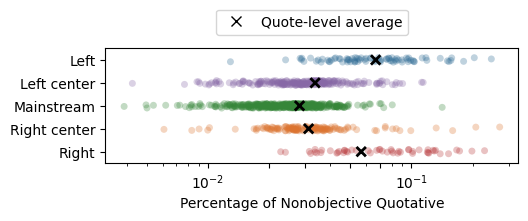

In [6]:
domain_level = quote_centric_regression.groupby(["outlet_category", "domain"])\
    .agg({"unprofessional_verb": "mean", "relative_time": "count"}).reset_index()

overall =  quote_centric_regression.groupby(["outlet_category"])\
    .agg({"unprofessional_verb": "mean", "relative_time": "count"}).reset_index()

fig, axs = plt.subplots(1, 1,sharey='all',figsize=(10.56/2,2.2), dpi=100)

sns.stripplot(
    data=domain_level, x="unprofessional_verb", y="outlet_category",
    jitter=True, s=5, alpha=.3, order=categories, palette=[color_dict[x] for x in categories],
    zorder=1
)

sns.pointplot(data=overall, x="unprofessional_verb", y="outlet_category", 
              order=categories, zorder=30, color="black", 
              linestyles="", markers="x")


plt.xscale("log")
axs.set_xticks([0.01, 0.02, 0.03, 0.05, 0.07, 0.1])
axs.set_yticklabels([title_dict[x] for x in categories])
axs.set_ylabel("")
axs.set_xlabel("Percentage of Nonobjective Quotative")
custom_lines = [Line2D([0], [0], color="black", lw=0, marker="x", markersize=7)]
axs.legend(custom_lines, ['Quote-level average'], loc="upper center", bbox_to_anchor=(.5, 1.4))

set_size(fig, (10.56/2,2.2))

fig.savefig(IMAGEPATH + "avg.pdf", bbox_inches="tight")

# Figure 4: Overall Trend

In [ ]:
tmp = quote_centric_regression.groupby(["relative_time"]).demeaned.agg([
    "mean", "count"]).reset_index()
fig_overall, ax = plt.subplots(1,figsize=(10.56/2,3), dpi=200)
tmp['mean']*=100
tmp_ = tmp.copy(deep=True)
mod = smf.wls(formula='mean ~ relative_time', data=tmp_, weights=tmp_["count"])
res = mod.fit()
#     print(res.summary())
#     tmp_["mean"] =  tmp_["mean"] - res.params["Intercept"]
ax.plot([0, 83], [res.params["Intercept"], 83*res.params["relative_time"]], '#4B371C')

sns.regplot(x="relative_time", y = "mean", data=tmp_, 
            scatter_kws={"s": 3, "alpha": 1}, color='#4B371C', ax=ax, fit_reg=False)
ax.set_xticks([8,39,74])
ax.set_xticklabels(['2014','2017','2020'])
#     ax.axhline(0, ls=":", color="black", alpha=0.5, lw=2)
ax.set_ylabel("")
ax.set_xlabel("Year")
ax.set_ylabel("% Nonobjective\nQuotative (centered)")
ax.set_ylabel("% Nonobjective\nQuotative (centered)")
set_size(fig, (10.56,2))


fig_overall.savefig(IMAGEPATH + "trends_overall.pdf", bbox_inches="tight")
fig_overall.savefig(IMAGEPATH + "trends_overall.png", bbox_inches="tight")

# Figure 5: Outlet-level and category level averages

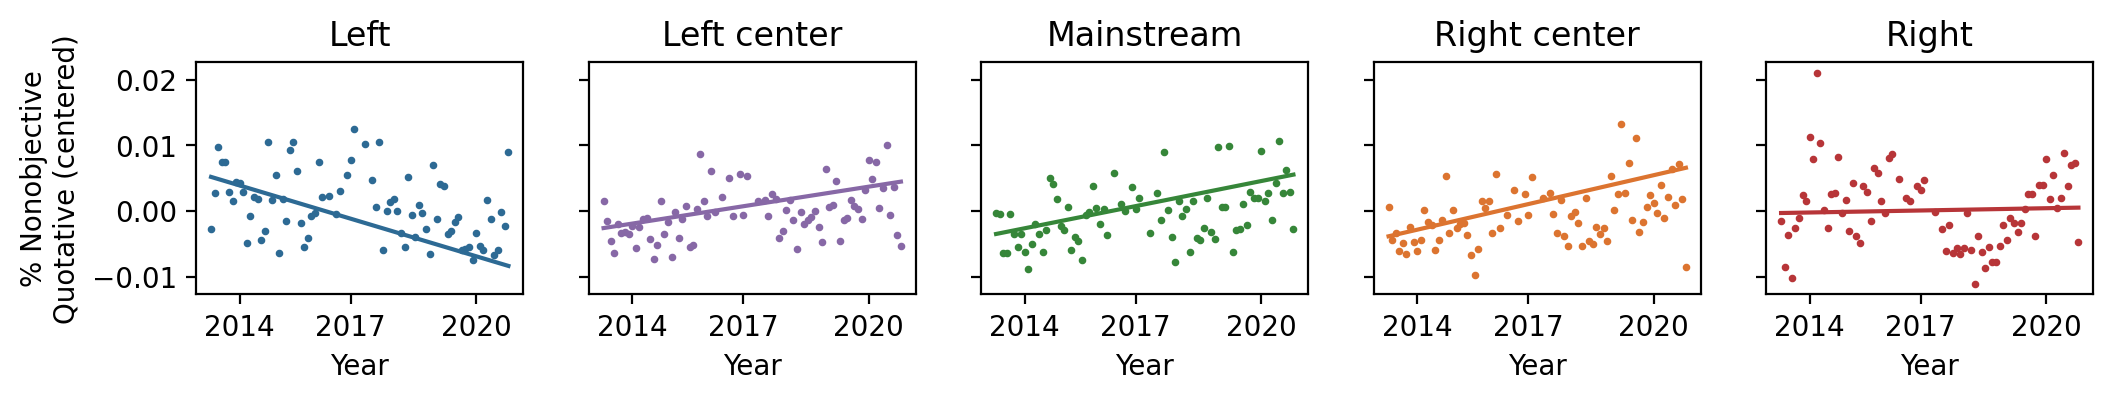

In [7]:
tmp = quote_centric_regression.groupby(["outlet_category", "relative_time"]).demeaned.agg([
    "mean", "count"]).reset_index()
fig, axs = plt.subplots(1, 5,sharey='all',figsize=(10.56,2),dpi=200)


for idx, i in enumerate(["left", "left_center", "mainstream", "right_center", "right"]):
    ax = axs[idx]
    tmp_ = tmp[tmp.outlet_category == i].copy(deep=True)
    mod = smf.wls(formula='mean ~ relative_time', data=tmp_, weights=tmp_["count"])
    res = mod.fit()
#     print(res.summary())
#     tmp_["mean"] =  tmp_["mean"] - res.params["Intercept"]
    ax.plot([0, 83], [res.params["Intercept"], 83*res.params["relative_time"]], color_dict[i])
    
    sns.regplot(x="relative_time", y = "mean", data=tmp_, 
                scatter_kws={"s": 3, "alpha": 1}, color=color_dict[i], ax=ax, fit_reg=False)
    ax.set_xticks([8,39,74])
    ax.set_xticklabels(['2014','2017','2020'])
#     ax.axhline(0, ls=":", color="black", alpha=0.5, lw=2)
    ax.set_ylabel("")
    ax.set_title(title_dict[i])
    ax.set_xlabel("Year")
    
axs[0].set_ylabel("% Nonobjective\nQuotative (centered)")
axs[0].set_ylabel("% Nonobjective\nQuotative (centered)")
set_size(fig, (10.56,2))

fig.savefig(IMAGEPATH + "trends.pdf", bbox_inches="tight")